In [146]:
%reload_ext autoreload
%autoreload 2

In [147]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [148]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [149]:
# combine all json file in all-weeks8-9

from src.loader import SlackDataLoader

# Initialize DataLoader
data_loader  = SlackDataLoader

# Load data from a Slack channel

slack_data = data_loader.slack_parser('../data/all-week1/')

slack_data.columns

Index(['msg_type', 'msg_content', 'sender_name', 'msg_sent_time',
       'msg_dist_type', 'time_thread_start', 'reply_count',
       'reply_users_count', 'reply_users', 'tm_thread_end', 'channel'],
      dtype='object')

Top 10 users by replaying count

In [150]:
top_10_replaying_users = slack_data.groupby('sender_name')['reply_count'].sum().nlargest(10)

top_10_replaying_users

sender_name
Cristian Wilson     76
Michelle Lewis      60
Veronica Padilla    37
Brenda Hernandez    34
Katie Dickerson     24
Joshua Rhodes       19
Mark Crawford       12
Steven Garcia       12
Anita Rodriguez     11
Kelly Soto           9
Name: reply_count, dtype: int64

Bottom 10  users by replying count

In [151]:
bottom_10_replaying_users = slack_data.groupby('sender_name')['reply_count'].sum().nsmallest(10)

bottom_10_replaying_users


sender_name
Anthony Galloway    0
Brady Rhodes        0
David Scott         0
Jennifer Foley      0
John Romero         0
Joseph Diaz         0
Katherine Foster    0
Leah Newton         0
Luis Ingram         0
Mandy Sweeney       0
Name: reply_count, dtype: int64

Top 10  users by mention

In [152]:
top_10_mention_users = slack_data.groupby('sender_name')['msg_content'].apply(lambda x: x.str.count('@').sum()).nlargest(10)

top_10_mention_users


sender_name
Veronica Padilla    17
Brenda Hernandez    11
Cristian Wilson      7
Brian Odom           5
Katie Dickerson      5
Phillip Atkins       5
Carlos Gross         4
Joshua Rhodes        4
Katherine Foster     4
Michelle Lewis       4
Name: msg_content, dtype: int64

Bottom 10  users by mention

In [153]:
bottom_10_mention_users = slack_data.groupby('sender_name')['msg_content'].apply(lambda x: x.str.count('@').sum()).nsmallest(10)

bottom_10_mention_users


sender_name
Ashley Hamilton    0
Daniel Brown       0
David Scott        0
Dustin Wilson      0
Jodi Lyons         0
John Romero        0
Kelly Soto         0
Leah Newton        0
Luis Ingram        0
Melissa Ingram     0
Name: msg_content, dtype: int64

Top 10  users by message count

In [154]:
top_10_message_users = slack_data['sender_name'].value_counts().nlargest(10)

top_10_message_users

sender_name
Cristian Wilson     66
Brenda Hernandez    52
Travis Butler       45
Michelle Lewis      42
Veronica Padilla    35
Katie Dickerson     30
Joshua Rhodes       27
Brittany Garcia     24
Phillip Atkins      21
April Lucas         17
Name: count, dtype: int64

Bottom 10  users by message count

In [155]:
bottom_10_message_users = slack_data['sender_name'].value_counts().nsmallest(10)

bottom_10_mention_users

sender_name
Ashley Hamilton    0
Daniel Brown       0
David Scott        0
Dustin Wilson      0
Jodi Lyons         0
John Romero        0
Kelly Soto         0
Leah Newton        0
Luis Ingram        0
Melissa Ingram     0
Name: msg_content, dtype: int64

Top 10  users by reaction count

In [156]:
top_10_reaction_users = slack_data.groupby('sender_name')['reply_users_count'].sum().nlargest(10)

top_10_reaction_users

sender_name
Michelle Lewis      39
Cristian Wilson     38
Brenda Hernandez    24
Katie Dickerson     20
Veronica Padilla    18
Joshua Rhodes        9
Mark Crawford        7
Anita Rodriguez      6
Judith Bolton        6
Travis Butler        6
Name: reply_users_count, dtype: int64

Bottom 10  users by reaction count

In [157]:
bottom_10_reaction_users = slack_data.groupby('sender_name')['reply_users_count'].sum().nsmallest(10)

bottom_10_reaction_users

sender_name
Anthony Galloway    0
Brady Rhodes        0
David Scott         0
Jennifer Foley      0
John Romero         0
Joseph Diaz         0
Katherine Foster    0
Leah Newton         0
Luis Ingram         0
Mandy Sweeney       0
Name: reply_users_count, dtype: int64

Top 10 messages by replies

In [158]:
top_10_messages_by_replies = slack_data.nlargest(10, 'reply_count')

top_10_messages_by_replies[['msg_content', 'reply_count']]


,msg_content,reply_count
456,I need some one who understood task two to ask...,18
345,<@U03UKL27B0R> I have used sum but it didn't s...,14
169,"What are you guys using for your work please, ...",12
463,What is everybody using to measure session fre...,12
434,I suggest that if the managing team made a sh...,10
539,<@U03V8LHPDME> <@U03UKL27B0R> <@U03U9DB7REG> a...,10
70,anyone who have an idea on how to use utility...,9
45,<!here> <!channel> I appreciate if anyone can ...,8
23,"I think that if we replace them, we will chang...",7
145,"One moment my notebook will work, the next mom...",7


Top 10 message by reaction

In [159]:
top_10_messages_by_reactions = slack_data.nlargest(10, 'reply_users_count')

top_10_messages_by_reactions[['msg_content', 'reply_users_count']]

,msg_content,reply_users_count
169,"What are you guys using for your work please, ...",5
348,Does the &lt;number of xDR sessions&gt; task 1...,5
434,I suggest that if the managing team made a sh...,5
5,"What does this mean please ""Milliseconds offse...",4
16,i used &lt;MSISDN/Number&gt;. because I think ...,4
23,"I think that if we replace them, we will chang...",4
38,"Hello everyone, how are you doing?\nI got a pr...",4
251,"Just to be clear, today's submission would be ...",4
283,"Any have information, on the time the next ses...",4
345,<@U03UKL27B0R> I have used sum but it didn't s...,4


Top 10 message by mention

In [160]:
slack_data['mention_count'] = slack_data['msg_content'].apply(lambda x: x.count('@'))

top_messages_by_mentions = slack_data.nlargest(10, 'mention_count')
top_messages_by_mentions[['msg_content', 'mention_count']]


,msg_content,mention_count
490,What do instructions say <@U03UJGP0C68> ? <@U0...,3
539,<@U03V8LHPDME> <@U03UKL27B0R> <@U03U9DB7REG> a...,3
1,<@U03UKL27B0R> and <@U03UKGSDGSG> Thanks a lot,2
80,Thank you <@U03UKL27B0R> <@U03UUR571A5>,2
102,<!here> <!channel> <@U03V8LHPDME> <@U03UKL27B0...,2
117,<@U03V1AM5TFA> <@U03TEPYRM2P> Isn't there any ...,2
119,Thank you <@U03TEPYRM2P> and <@U03UVHCV6KB>. I...,2
201,Thank you <@U03UJGRN5E0> and <@U03UH397319>.,2
204,Thank You<@U03U9EJR362> and <@U03UJN29Y4C>,2
224,thank you <@U03UH397319> <@U03UKL27B0R> it is ...,2


In [161]:

data_loader = SlackDataLoader
for week in range(1, 13):
    week_channel_variable_name = f'week{week}_channel'
    week_path = f'../data/all-week{week}/'

    globals()[week_channel_variable_name] = data_loader.slack_parser(week_path)

weeks = [week1_channel, week2_channel, week3_channel, week4_channel, week5_channel, week6_channel, week7_channel, week8_channel, week9_channel, week10_channel, week11_channel, week12_channel]

for i, week in enumerate(weeks, start=1):
    week['channel'] = i

# Concatenate all dataframes into a single dataframe
concated_data = pd.concat(weeks, ignore_index=True)

Which channel has the highest activity?

The most highest activity is on  channel : 1


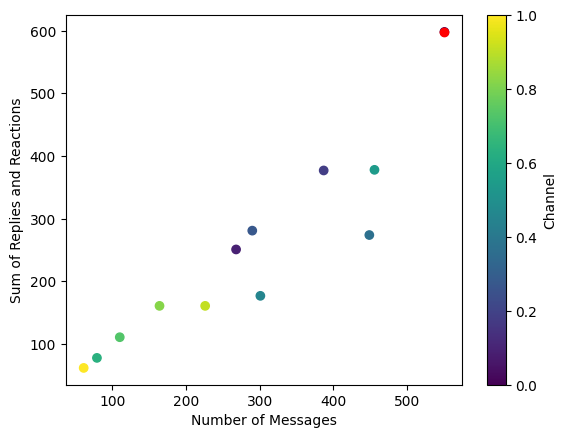

In [162]:

channel_activity = concated_data.groupby('channel').agg({
    'msg_content': 'count',
    'reply_count': 'sum',
    'reply_users_count': 'sum'
}).reset_index()

# Calculate the sum of replies and reactions
channel_activity['replies_and_reactions'] = channel_activity['reply_count'] + channel_activity['reply_users_count']

# Identify the most active channel
most_active_channel = channel_activity.loc[channel_activity['replies_and_reactions'].idxmax()]

# Create a scatter plot
plt.scatter(channel_activity['msg_content'], channel_activity['replies_and_reactions'], c=channel_activity['channel'])

# Highlight the most active channel
plt.scatter(most_active_channel['msg_content'], most_active_channel['replies_and_reactions'], color='red', marker='o')

# Set axis labels
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies and Reactions')

cbar = plt.colorbar()
cbar.set_label('Channel')

print(f"The most highest activity is on  channel : {most_active_channel['channel']}")


/tmp/ipykernel_4586/154863959.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_df['time_thread_start'] = pd.to_datetime(new_df['time_thread_start'], errors='coerce')


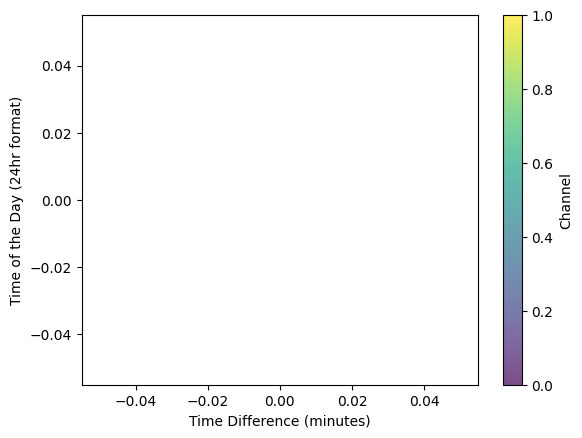

In [163]:

new_df = concated_data


# Assuming 'msg_sent_time' has a consistent format, replace '%Y-%m-%d %H:%M:%S' with the actual format
new_df['msg_sent_time'] = pd.to_datetime(new_df['msg_sent_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
new_df['time_thread_start'] = pd.to_datetime(new_df['time_thread_start'], errors='coerce')

# Drop rows with missing or invalid timestamps
new_df = new_df.dropna(subset=['msg_sent_time', 'time_thread_start'])

# Calculate the time difference in minutes
new_df['time_difference'] = (new_df['time_thread_start'] - new_df['msg_sent_time']).dt.total_seconds() / 60

# Extract the time of the day in 24hr format
new_df['time_of_day'] = new_df['msg_sent_time'].dt.hour + new_df['msg_sent_time'].dt.minute / 60

# Filter data for messages replied within the first 5 minutes
replied_within_5mins = new_df[new_df['time_difference'] <= 5]

# Create a scatter plot with color representing channels
plt.scatter(
    replied_within_5mins['time_difference'],
    replied_within_5mins['time_of_day'],
    c=replied_within_5mins['channel'],
    cmap='viridis',  # You can choose a different colormap
    alpha=0.7
)

# Set axis labels
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Time of the Day (24hr format)')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Channel')

# Show the plot
plt.show()



## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [164]:
# which user has the highest number of reply counts?



In [165]:
# Visualize reply counts per user per channel

In [166]:
# what is the time range of the day that most messages are sent?


In [167]:
# what kind of messages are replied faster than others?

In [168]:
# Relationship between # of messages and # of reactions

In [169]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [170]:
# Which users got the most reactions?

In [171]:
# Model topics mentioned in the channel

In [172]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [173]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?